# Unsupervised Learning on LendingClub data
Can Kmeans, MiniBatch Kmeans and MeanShift predict bad loan?

1. Use 2 cluster to see how well Kmean and miniKmeans can predict bad loans
2. Use the top 10 features in Random Forest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.preprocessing import Normalizer, normalize, scale
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('lending_club_le.csv',index_col=0)

In [3]:
df.head(3)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,collections_12_mths_ex_med,open_acc_6m,mths_since_rcnt_il,il_util,max_bal_bc,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type
5,3000.0,52000.0,0.58,0.0,0.0,0.0,0.0,7.0,67.990156,141.0,...,9,3,1,0,5,46,253,5,1,0
14,5000.0,55000.0,14.18,0.0,0.0,0.0,1.0,33.0,63.000000,4829.0,...,1,2,0,0,8,10,90,346,1,0
23,20300.0,55000.0,26.63,0.0,0.0,0.0,0.0,24.0,74.000000,8215.0,...,10,3,2,0,1,33,523,756,1,0


In [4]:
df.shape

(87923, 42)

In [5]:
df.bad_loan.value_counts()

0    65793
1    22130
Name: bad_loan, dtype: int64

---

# Kmeans vs MiniBatchKmeans analysis

How accurately will Kmeans cluster data for bad loan data?

## Kmeans

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


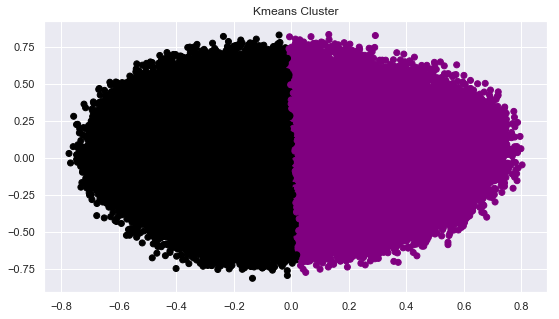

Comparing k-means clusters against the data:
bad_loan      0      1
row_0                 
0         33684  11429
1         32109  10701


In [40]:
colormap = np.array(['black', 'Purple'])
X_norm = normalize(scale(df.drop(['bad_loan'], axis=1)))
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2, random_state=42, n_jobs=-1).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, df['bad_loan']))

_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

Looks like this model isn't doing very well. We're __correctly classifying 44,298 (32108+11431)__ cases, but __mis-classifying 43,625 (333685+10699)__ of the cases!

Out of __87,923__ loan applicatons __33717__ were bad loans which were predict correctly. There are way to many false positives(__32076__).


-----

## Kmeans Mini Batch

_Let's look at MiniBatch to see if that would be better_

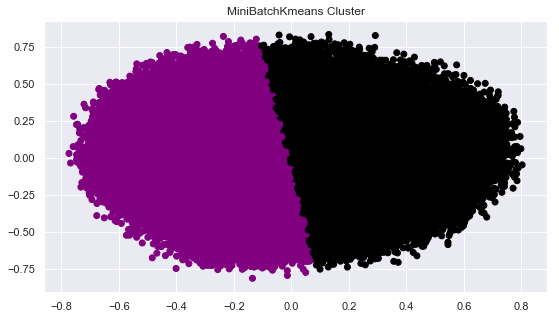

Comparing k-means and mini batch k-means solutions:
bad_loan      0      1
row_0                 
0         33352  11115
1         32441  11015


In [39]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=250)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
colormap = np.array(['black', 'Purple'])
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, df['bad_loan']))

MiniBatch Kmeans is able to __classify 43,207 (32263+10944)___ and __mis-classify 44,716 (11186+33530)__.

-----

-------

# Clustering the Top 10 Random Forest features
_I will take the top 10 features from the Random Forest supervised learning
I will run it on both Kmeans and MeanShift_

In [19]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

df1 = pd.read_csv('lending_club_le.csv',index_col=0)

_Create the dataframes of the top 10 features_

In [20]:
topFeatures = df1[['loan_amnt',
                   'tot_hi_cred_lim',
                   'home_ownership',
                   'verification_status',
                   'dti',
                   'percent_bc_gt_75',
                   'mo_sin_old_rev_tl_op',
                   'all_util',
                   'mths_since_recent_inq',
                   'annual_inc']]

_Elbow method to determine the number of clusters_

In [21]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

---

## KMeans RFC top 10 feature analysis

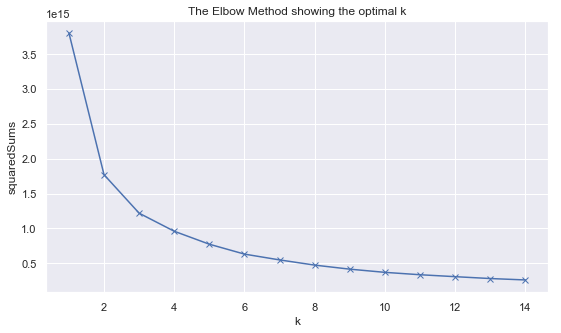

In [22]:
kClusters(topFeatures)

In [23]:
norm = Normalizer(copy=False)
X_normalized = norm.fit_transform(topFeatures)

km = KMeans(n_clusters=4,
               init='k-means++')

km_clusters = km.fit_predict(X_normalized)

centroids = km.cluster_centers_
km_labels = km.labels_

topFeatures['Clusters'] = km_clusters

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':



cluster 0
loan_amnt                 15056.914710
tot_hi_cred_lim          135136.801811
home_ownership                2.103942
verification_status           0.810424
dti                          20.747554
percent_bc_gt_75             27.366911
mo_sin_old_rev_tl_op        169.271224
all_util                     53.258685
mths_since_recent_inq         6.688682
annual_inc                78405.170037
Clusters                      0.000000
Name: mean, dtype: float64


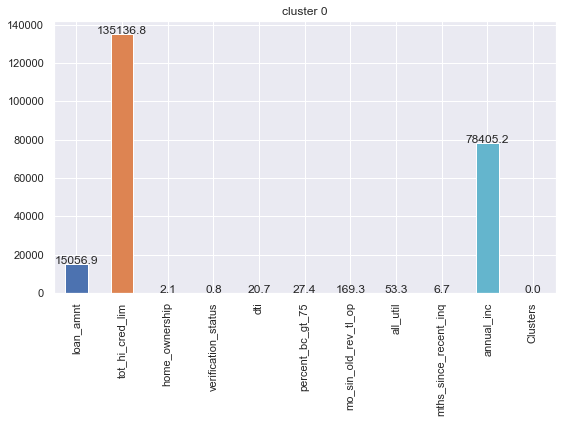


cluster 1
loan_amnt                 15940.970159
tot_hi_cred_lim          332194.506844
home_ownership                1.251538
verification_status           0.924403
dti                          22.175357
percent_bc_gt_75             30.780889
mo_sin_old_rev_tl_op        188.575915
all_util                     53.844949
mths_since_recent_inq         6.413985
annual_inc                80850.338084
Clusters                      1.000000
Name: mean, dtype: float64


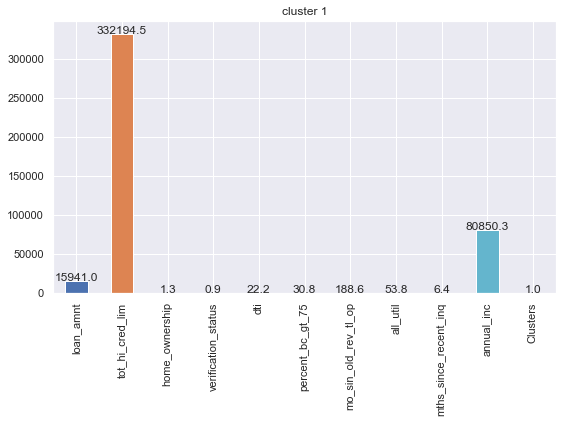


cluster 2
loan_amnt                13813.410523
tot_hi_cred_lim          31885.553988
home_ownership               2.516015
verification_status          0.781918
dti                          7.916598
percent_bc_gt_75            30.562471
mo_sin_old_rev_tl_op       145.722828
all_util                    49.561018
mths_since_recent_inq        6.814749
annual_inc               91472.125961
Clusters                     2.000000
Name: mean, dtype: float64


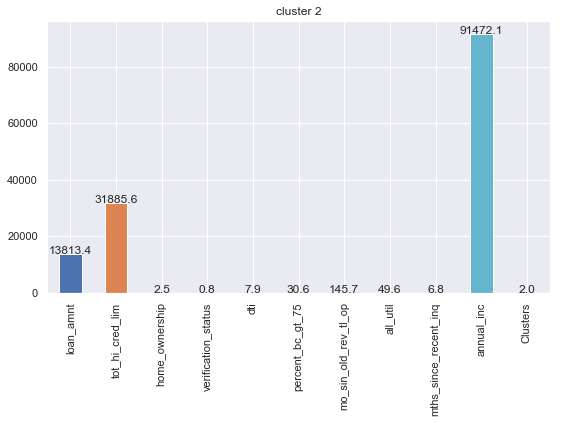


cluster 3
loan_amnt                14651.557720
tot_hi_cred_lim          63749.405302
home_ownership               2.485000
verification_status          0.794665
dti                         16.287175
percent_bc_gt_75            30.061996
mo_sin_old_rev_tl_op       155.777116
all_util                    52.938174
mths_since_recent_inq        6.927478
annual_inc               72970.942252
Clusters                     3.000000
Name: mean, dtype: float64


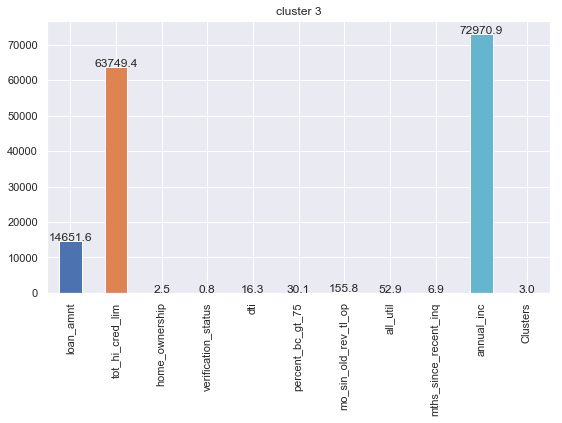

In [24]:
sns.set(style="darkgrid")
clusterList = [0, 1, 2, 3]
for var in clusterList:
    print('\ncluster '+str(var))
    print(topFeatures[topFeatures['Clusters'] == var].describe().loc['mean'])
    ax = topFeatures[topFeatures['Clusters'] ==
                     var].describe().loc['mean'].plot(kind='bar')
    plt.title('cluster '+str(var))
    for p in ax.patches:  # https://stackoverflow.com/questions/31749448/
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 5,
                '{:1.1f}'.format(height),
                ha="center")

    plt.show()

__Match the KMean clusters to labels.__

In [25]:
topFeatures.tail()

,loan_amnt,tot_hi_cred_lim,home_ownership,verification_status,dti,percent_bc_gt_75,mo_sin_old_rev_tl_op,all_util,mths_since_recent_inq,annual_inc,Clusters
610845,25000.0,399078.0,3,0,25.09,100.0,144.0,93.0,3.000000,100000.0,1
610851,1000.0,13808.0,3,0,18.40,0.0,40.0,38.0,7.000000,18000.0,3
610867,32000.0,1021882.0,1,1,5.41,0.0,239.0,20.0,7.521675,170000.0,1
610898,6500.0,184448.0,1,0,34.78,100.0,296.0,66.0,1.000000,70000.0,1
610900,20000.0,116838.0,3,0,32.75,0.0,227.0,32.0,0.000000,55000.0,0


### Group the number of clusters and find the averages of the top 10 features.

In [26]:
for var in topFeatures:
    print(var , topFeatures[var].groupby(topFeatures['Clusters']).mean(),'\n')

loan_amnt Clusters
0    15056.914710
1    15940.970159
2    13813.410523
3    14651.557720
Name: loan_amnt, dtype: float64 

tot_hi_cred_lim Clusters
0    135136.801811
1    332194.506844
2     31885.553988
3     63749.405302
Name: tot_hi_cred_lim, dtype: float64 

home_ownership Clusters
0    2.103942
1    1.251538
2    2.516015
3    2.485000
Name: home_ownership, dtype: float64 

verification_status Clusters
0    0.810424
1    0.924403
2    0.781918
3    0.794665
Name: verification_status, dtype: float64 

dti Clusters
0    20.747554
1    22.175357
2     7.916598
3    16.287175
Name: dti, dtype: float64 

percent_bc_gt_75 Clusters
0    27.366911
1    30.780889
2    30.562471
3    30.061996
Name: percent_bc_gt_75, dtype: float64 

mo_sin_old_rev_tl_op Clusters
0    169.271224
1    188.575915
2    145.722828
3    155.777116
Name: mo_sin_old_rev_tl_op, dtype: float64 

all_util Clusters
0    53.258685
1    53.844949
2    49.561018
3    52.938174
Name: all_util, dtype: float64 

mths_sin

---------

## Mean shift top 10 feature analysis

In [27]:
#topFeatures2 = topFeatures.drop(
#   ['clusters'], axis=1)

topFeatures2 = df1[['loan_amnt',
                   'tot_hi_cred_lim',
                   'max_bal_bc',
                   'emp_title',
                   'dti',
                   'mo_sin_old_il_acct',
                   'mo_sin_old_rev_tl_op',
                   'all_util',
                   'revol_util',
                   'annual_inc']]

In [28]:
bandwidth2 = estimate_bandwidth(topFeatures2,
                                quantile=0.2,
                                n_samples=10)
# introduce the radius, also create bins to store the clusters.
ms = MeanShift(bandwidth2, 
               bin_seeding=True)

In [29]:
ms.fit(topFeatures2)
msLabels = ms.labels_

In [30]:
msLabels

array([0, 0, 0, ..., 1, 0, 0])

In [31]:
dict1 = {}
for var in zip(topFeatures2, msLabels):
    dict1[var[0]] = var[1]
    # if var[1] == 65:
    # print(var)

_This dictionary has the feature and the cluster number it belongs too_

In [32]:
dict1

{'loan_amnt': 0,
 'tot_hi_cred_lim': 0,
 'max_bal_bc': 0,
 'emp_title': 0,
 'dti': 0,
 'mo_sin_old_il_acct': 0,
 'mo_sin_old_rev_tl_op': 0,
 'all_util': 0,
 'revol_util': 0,
 'annual_inc': 0}

In [33]:
clusters = pd.DataFrame(list(dict1.items()), columns=[
                        'Features', 'Cluster'])
clusters

,Features,Cluster
0,loan_amnt,0
1,tot_hi_cred_lim,0
2,max_bal_bc,0
3,emp_title,0
4,dti,0
5,mo_sin_old_il_acct,0
6,mo_sin_old_rev_tl_op,0
7,all_util,0
8,revol_util,0
9,annual_inc,0


In [34]:
clusters['Cluster'].value_counts()

0    10
Name: Cluster, dtype: int64

_MeanShift didn't find any new features._

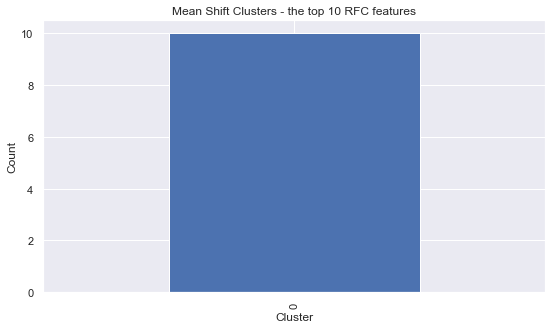

In [35]:
clusters.groupby('Cluster')['Features'].nunique().plot(kind='bar');
plt.ylabel('Count')
plt.title('Mean Shift Clusters - the top 10 RFC features');

Mean shift was not able to find new clusters